# Kinematics recovery using axisymmetric JAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from copy import deepcopy
import h5py

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)
import matplotlib.patches as patches

from scipy.stats import gaussian_kde
from scipy.stats import truncnorm

from deproject.Util.ellipticity import Axis_ratio2ellipticity, Ellipticity2axis_ratio 
from deproject.projection_axisymmetric import Projection_axisym
from deproject.Util.random_var import Draw_from_pdf

from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
# from deproject.Kinematics.mge_misc import sum_gaussian_components, plot_mge

In [2]:
oblate = True

if oblate:
    oblate_name = 'oblate'
else:
    oblate_name = 'prolate'

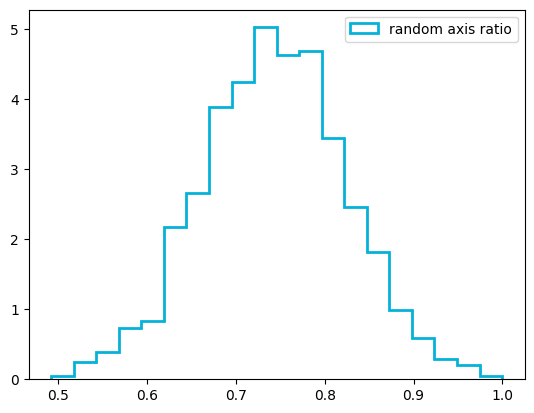

In [3]:
def qintr_prior(mu, sigma, num): # sample q_intr from truncated Gaussian prior
    lo_lim, hi_lim = 0, 1
    lo_transformed = (lo_lim - mu) / sigma
    hi_transformed = (hi_lim - mu) / sigma
    qintr_prior = truncnorm(lo_transformed, hi_transformed, loc = mu, scale = sigma)
    return qintr_prior.rvs(size = num)

if oblate:
    mu_qintr, sigma_qintr = 0.74, 0.08
else:
    mu_qintr, sigma_qintr = 0.84, 0.04


qintr_rm = qintr_prior(mu_qintr, sigma_qintr, 800)

plt.hist(qintr_rm, histtype='step', lw=2, label = 'random axis ratio', density = True, bins = 20)

plt.legend()
plt.show()

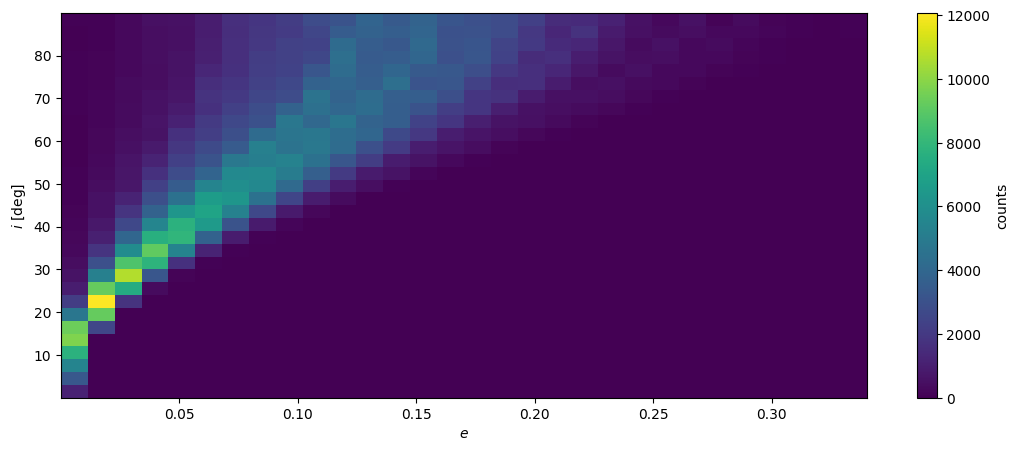

In [4]:
projection_axisym = Projection_axisym(qintr_rm) 

eobs_rm, inc_iso_rm = projection_axisym.Eobs_dist_iso_inc(plot_scatter=0, plot_2dhist=0, single_proj=1000, bins_2dhist_plot=[40, 30]) # test 

plt.figure(figsize = (13, 5))
hist, xedges, yedges = np.histogram2d(eobs_rm, np.degrees(inc_iso_rm), bins=30)
xcoord, ycoord = np.meshgrid(xedges, yedges)
plt.pcolormesh(xcoord, ycoord, hist.T)
plt.colorbar(label = 'counts')
# plt.xticks(np.arange(0, 0.6, 0.1))
plt.xlabel('$e$')
plt.ylabel('$i$ [deg]')
plt.show()

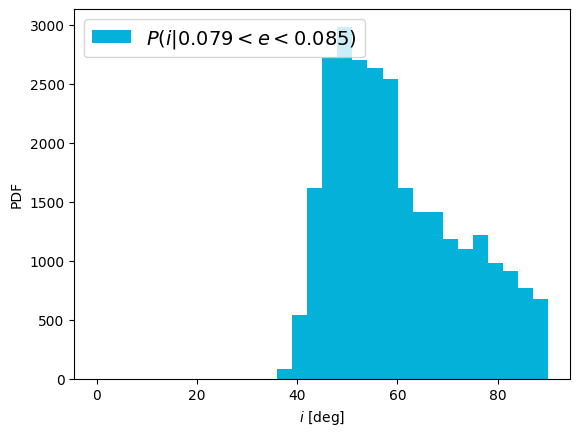

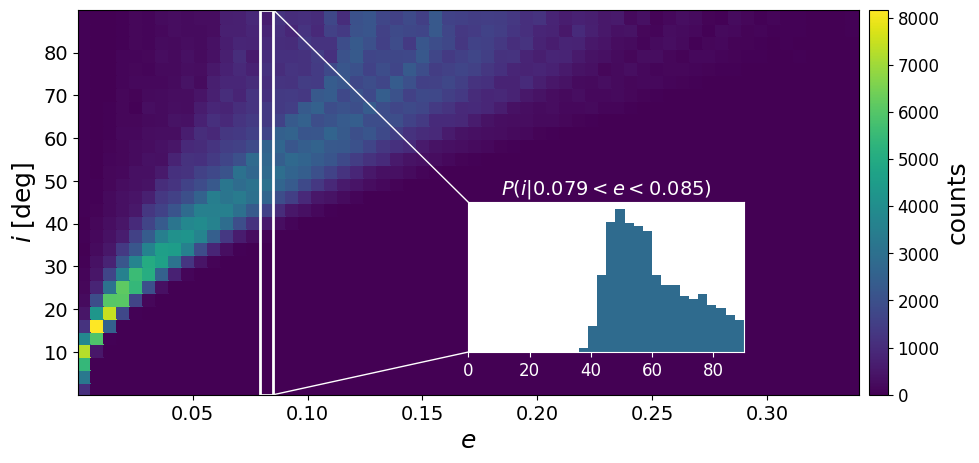

In [5]:
kwargs_eobs_iso_inc = {'single_proj': 1000, 'plot_2dhist': 0, 'bins_2dhist_plot': [30, 30], 'plot_scatter': 0}

e_example = 0.08 # here the observed ellipticity is 0.08
bins_2dhist = [60, 30]
hist, xedges, yedges = np.histogram2d(eobs_rm, np.degrees(inc_iso_rm), bins=bins_2dhist)
bin_ind = np.digitize(e_example, xedges) - 1

bins, counts = projection_axisym.Cond_pdf_inc_given_eobs(e_example, plot_1dpdf=0, bins_2dhist=bins_2dhist, normalize=0, **kwargs_eobs_iso_inc, quiet=1)

plt.figure()
plt.bar(np.degrees(bins[:-1]), counts, align='edge', width=np.diff(np.degrees(bins)), label = r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]))
plt.ylabel('PDF')
plt.xlabel('$i$ [deg]')
# plt.title(r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]))
plt.legend(prop = {'size': 14}, loc='upper left')
plt.show()


fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111)
xcoord, ycoord = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(xcoord, ycoord, hist.T)
pcm.set_edgecolor('face')
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
plot_width = np.diff(xedges)[0]
plot_height = y_max - y_min
rect = plt.Rectangle((xedges[bin_ind], y_min), plot_width, plot_height, fill=False, edgecolor='w', linewidth=2)
ax.add_patch(rect)
cbar = fig.colorbar(pcm, ax=ax, pad=0.01)
cbar.set_label('counts', size = 18)
# ax.set_xticks(np.arange(0, 0.6, 0.1))
plt.xlabel('$e$', size = 18)
plt.ylabel('$i$ [deg]', size = 18)
plt.xticks(size = 14)
plt.yticks(size = 14)
cbar.ax.tick_params(labelsize=12) 

# plot a slice of the histogram
insert_x0, insert_y0, insert_width, insert_height = 0.17, 10, 0.12, 35
insert_ax = ax.inset_axes([insert_x0, insert_y0, insert_width, insert_height], transform=ax.transData)
insert_ax.bar(np.degrees(bins[:-1]), counts, align='edge', width=np.diff(np.degrees(bins)), label = r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]), color='#2f6b8e')
# insert_ax.set_xlabel('$i$', c='w')
insert_ax.set(xticks=np.arange(0, 90, 20), yticks=[])
for spine in insert_ax.spines.values():
    spine.set_edgecolor('w')
insert_ax.xaxis.label.set_color('w')
insert_ax.tick_params(color='w', labelcolor='w', labelsize=12)
insert_ax.set_title(r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]), fontsize = 14, color='w')
insert_ax.set_xlim([0, 90])

# plot axis connecting the slice and the 1d histogram
ax.plot([xedges[bin_ind+1], insert_x0], [y_max, insert_y0 + insert_height], marker = ' ', ls = '-', lw=1, color='w')
ax.plot([xedges[bin_ind+1], insert_x0], [y_min, insert_y0], marker = ' ', ls = '-', lw=1, color='w')

# plt.savefig('./eobs_vs_inc_2dhist_{}.pdf' .format(oblate_name), bbox_inches='tight', dpi=300)

plt.show()

del e_example, bins, counts, hist, xedges, yedges


## Access mock data 

In [6]:
rerun_calculation = False

if not rerun_calculation:
    # load saved data
    with h5py.File('./kin_recovery_axisym_{}.hdf5' .format(oblate_name), 'r') as f:
        print(f.keys())
        inc_recover_all = f['inc_recover_all'][:]
        inc_recover_iso_all = f['inc_recover_iso_all'][:]
        vel_disp_all = f['vel_disp_all'][:]
        vel_disp_iso_all = f['vel_disp_iso_all'][:]
        inc_recover_sel = f['inc_recover_sel'][:]
        inc_recover_iso_sel = f['inc_recover_iso_sel'][:]
        vel_disp_sel = f['vel_disp_sel'][:]
        vel_disp_iso_sel = f['vel_disp_iso_sel'][:]

<KeysViewHDF5 ['inc_recover_all', 'inc_recover_iso_all', 'inc_recover_iso_sel', 'inc_recover_sel', 'vel_disp_all', 'vel_disp_iso_all', 'vel_disp_iso_sel', 'vel_disp_sel']>


(600,)
(196,)


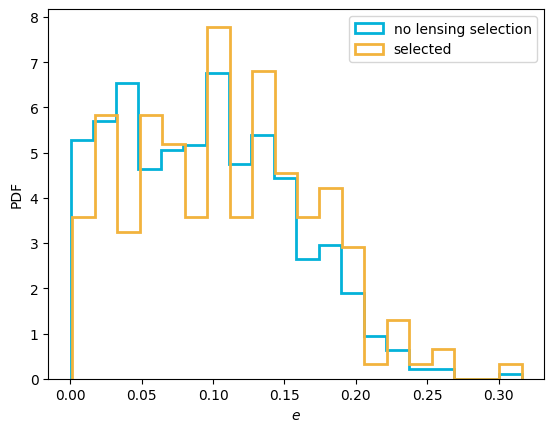

In [7]:
data = np.load('../fig5-fig6-make_kin_mock_data/kin_mock_data_{}.npy' .format(oblate_name))
data_copy = deepcopy(data)

qobs_data = data_copy[1, :]
theta_e_data = data_copy[0, :]
inc_data = data_copy[3, :]
sigma_e_data = data_copy[2, :]

if oblate:
    eobs_data = Axis_ratio2ellipticity(qobs_data)
else:
    eobs_data = -1 * Axis_ratio2ellipticity(qobs_data)
print(eobs_data.shape)

ind_sel = np.where(theta_e_data >= 1.2)[0]
eobs_data_sel = eobs_data[ind_sel]
qobs_data_sel = qobs_data[ind_sel]
inc_data_sel = inc_data[ind_sel]
sigma_e_data_sel = sigma_e_data[ind_sel]
print(eobs_data_sel.shape)

mean_sigma_e_data = np.mean(sigma_e_data)
mean_sigma_e_data_sel = np.mean(sigma_e_data_sel)

# plot data ellipticity
plt.figure()
plt.hist(eobs_data, bins = 20, label = 'no lensing selection', histtype='step', lw = 2, density=True)
plt.hist(eobs_data_sel, bins = 20, label = 'selected', histtype='step', lw = 2, density=True)
plt.legend(loc = 'best')
plt.xlabel('$e$')
plt.ylabel('PDF')
plt.show()

### Recover inclination angle from $P(i|e)$

#### The NO lensing selection sample

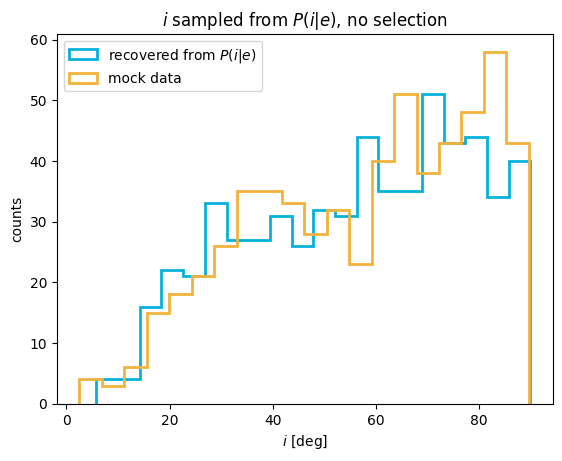

In [8]:
if rerun_calculation:
    inc_recover_all = projection_axisym.Recover_inclination(eobs_data, bins_2dhist=[60, 30], single_proj=1000)

plt.figure()
plt.hist(np.degrees(inc_recover_all), bins=20, label = r'recovered from $P(i\vert e)$', histtype='step', lw = 2)
plt.hist(inc_data, bins = 20, label = 'mock data', histtype='step', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title(r'$i$ sampled from $P(i|e)$, no selection')
plt.legend()
plt.show()

#### The lensing selected sample

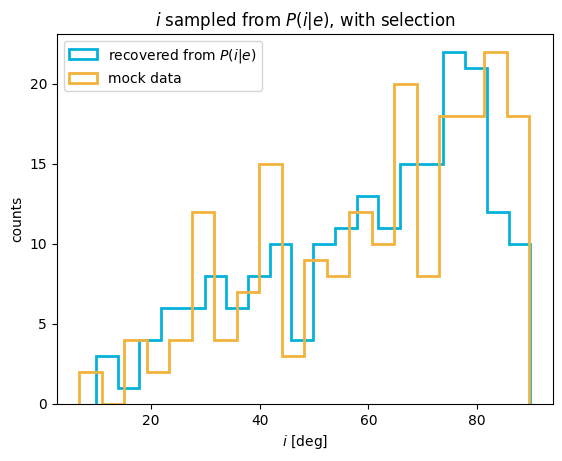

In [9]:
if rerun_calculation:
    inc_recover_sel = projection_axisym.Recover_inclination(eobs_data_sel, bins_2dhist=[60, 30], single_proj=1000)

plt.figure()
plt.hist(np.degrees(inc_recover_sel), bins=20, histtype='step', label = r'recovered from $P(i\vert e)$', lw = 2)
plt.hist(inc_data_sel, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title(r'$i$ sampled from $P(i|e)$, with selection')
plt.legend()
plt.show()

### Recover inclination angle from  isotropic distribution

#### The lensing selected sample

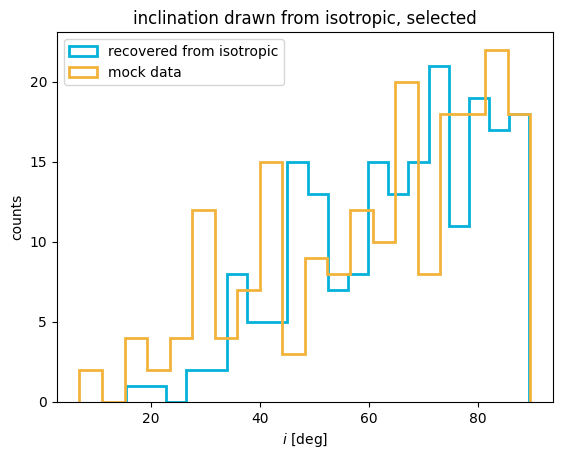

In [10]:
if rerun_calculation:
    inc_recover_iso_sel = projection_axisym.Recover_isotropic_inclination(eobs_data_sel)

plt.figure()
plt.hist(np.degrees(inc_recover_iso_sel), histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(inc_data_sel, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title('inclination drawn from isotropic, selected')
plt.legend()
plt.show()

#### The NO lensing selection sample

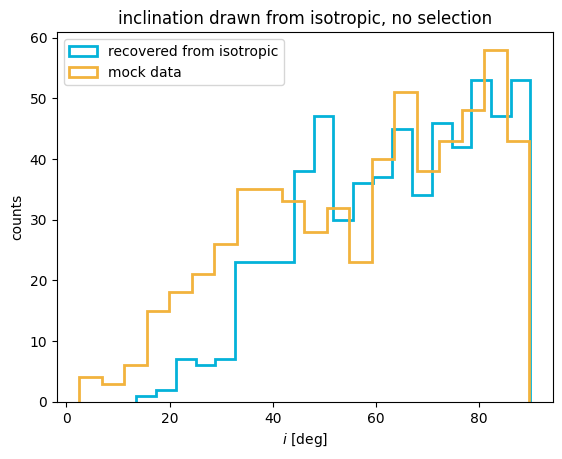

In [11]:
if rerun_calculation:
    inc_recover_iso_all = projection_axisym.Recover_isotropic_inclination(eobs_data)

plt.figure()
plt.hist(np.degrees(inc_recover_iso_all), histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(inc_data, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title('inclination drawn from isotropic, no selection')
plt.legend()
plt.show()

## Recover the kinematics with JAM

In [12]:
# access projected MGE.
with h5py.File('../fig5-fig6-make_kin_mock_data/kin_mock_data_mge_{}.hdf5' .format(oblate_name), 'r') as f:
    print(f.keys())
    peak_den = f['peak_den'][:]
    peak_lum = f['peak_lum'][:]
    sigma_den = f['sigma_den'][:]
    sigma_lum = f['sigma_lum'][:]

peak_den_sel = peak_den[ind_sel]
sigma_den_sel = sigma_den[ind_sel]
peak_lum_sel = peak_lum[ind_sel]
sigma_lum_sel = sigma_lum[ind_sel]

<KeysViewHDF5 ['peak_den', 'peak_lum', 'sigma_den', 'sigma_lum']>


In [13]:
def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin):
    """calculate velocity dispersion within the half-light radius from a jam model

    Args:
        surf_lum (_type_): peak of surface luminosity MGE 
        sigma_lum (_type_): sigma of surface luminocity MGE
        qobs_lum (_type_): array of the projected axis raio of the surface luminosity MGEs
        jam (_type_): jam model, a jampy.jam_axi_proj instance
        xbin (_type_): x coordinate to sample the velocity dispersion
        ybin (_type_): y coordinate to sample the velocity dispersion
        plot_velmap (int, optional): whether to plot the velocity dispersion map. Defaults to 0.
        plot_sample_points (int, optional): whether to plot the xy coordinates within the half-light radius. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    ifu_dim = int(np.sqrt(len(xbin)))
    if np.all(qobs_lum <= 1):
        flux = jam.flux
        reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)
    elif np.all(qobs_lum > 1):
        flux = np.reshape(jam.flux, (ifu_dim, ifu_dim)).T  # for prolate rotate the flux map by 90 degrees to calculate the half-light radius
        flux = flux.flatten() 
        reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, 1/qobs_lum)
    else:
        raise ValueError('Apparent axis ratio must be constant with radius!')

    w = xbin**2 + (ybin/(1 - eps_e))**2 < reff_maj**2

    model = jam.model

    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    return sig_e

In [14]:
lens_cosmo = get_default_lens_cosmo()
distance = lens_cosmo.Dd

In [15]:
def recover_vel_disp(peak_lum, sigma_lum, qobs_lum, peak_den, sigma_den, qobs_den, inclination, distance):
    """recover velocity dispersion from projected MGE components of the light and the mass

    Args:
        peak_lum (_type_): amplitude of the MGE describing the luminosity profile
        sigma_lum (_type_): dispersion of the MGE describing the luminosity profile
        qobs_lum (_type_): projected axis ratio of the MGE describing the luminosity profile
        peak_den (_type_): amplitude of the MGE describing the density profile
        sigma_den (_type_): dispersion of the MGE describing the density profile
        qobs_den (_type_): projected axis ratio of the MGE describing the density profile
        inclination (_type_): inclination angle
        distance (_type_): angular diameter distance to the system [Mpc]

    Returns:
        _type_: recovered velocity dispersion [km/s]
    """
    vel_disp = np.zeros(len(peak_den))
    inc_deg = np.degrees(inclination)
    for i in range(len(peak_den)):
        peak_lum_i = peak_lum[i]
        sigma_lum_i = sigma_lum[i]
        peak_den_i = peak_den[i]
        sigma_den_i = sigma_den[i]
        qobs_lum_i = qobs_lum[i]
        qobs_den_i = qobs_den[i]
        beta = np.zeros_like(peak_lum_i) # isotropic anisotropy

        if qobs_lum_i > 1:
            qobs_lum_i_apparent = 1 / qobs_lum_i # for Q>1, take the inverse to calculate reff
        else:
            qobs_lum_i_apparent = qobs_lum_i

        # set up a grid to perform jam 
        reff = mge_half_light_isophote(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i_apparent))[0]
        xx = np.linspace(-2.5 * reff, 2.5 * reff, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run jam
        jam = jam_axi_proj(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), peak_den_i, sigma_den_i, np.full_like(peak_den_i, qobs_den_i), inc_deg[i], 0, distance, xbin, ybin, plot=0, beta=beta, align='sph')
        # compute sigma_e
        sigma_e = get_sigma_e(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), jam, xbin, ybin)
        vel_disp[i] = sigma_e
        print(f"sigma_e: {sigma_e:.2f} km/s")

    return vel_disp

In [16]:
def percent_diff(a, b):
    return np.abs(a-b) / np.mean([a, b]) * 100

### With inclination angle recovered from $P(i|e$)
#### The lensing selected sample

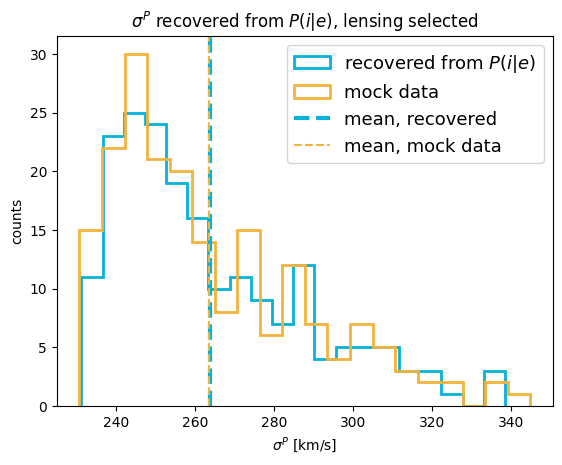

0.09125977218466208 %


In [17]:
if rerun_calculation:
    vel_disp_sel = recover_vel_disp(peak_lum_sel, sigma_lum_sel, qobs_data_sel, peak_den_sel, sigma_den_sel, qobs_data_sel, inc_recover_sel, distance)
mean_vel_disp_sel = np.mean(vel_disp_sel)

plt.figure()
plt.hist(vel_disp_sel, histtype='step', lw = 2, label = r'recovered from $P(i\vert e)$', bins=20)
plt.hist(sigma_e_data_sel, histtype='step', lw = 2, label = 'mock data', bins=20)
ax = plt.gca()
plt.axvline(mean_vel_disp_sel, marker = ' ', ls = '--', label = r'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data_sel, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from $P(i|e)$, lensing selected')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data_sel, mean_vel_disp_sel), '%')

#### The NO lensing selected sample

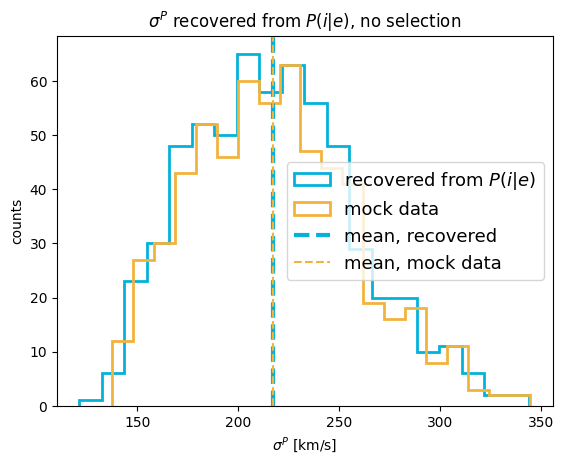

0.06668054822551812 %


In [18]:
if rerun_calculation:
    vel_disp_all = recover_vel_disp(peak_lum, sigma_lum, qobs_data, peak_den, sigma_den, qobs_data, inc_recover_all, distance) 
mean_vel_disp_no_sel = np.mean(vel_disp_all)

plt.figure()
plt.hist(vel_disp_all, histtype='step', lw = 2, label = r'recovered from $P(i\vert e)$', bins=20)
plt.hist(sigma_e_data, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_no_sel, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from $P(i|e)$, no selection')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data, mean_vel_disp_no_sel), '%')

### With inclination angle recovered from isotropic

#### The lensing selected sample

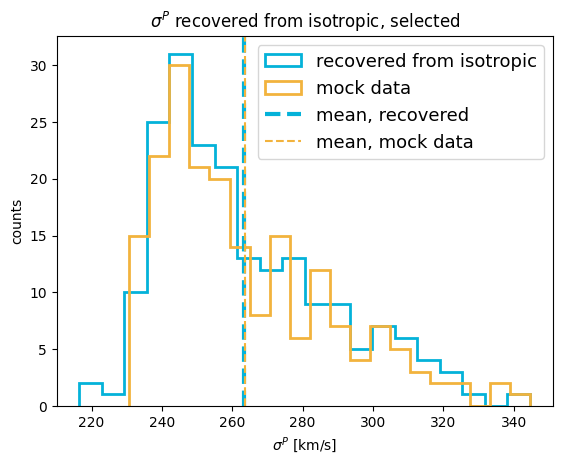

0.0966251295711949 %


In [19]:
if rerun_calculation:
    vel_disp_iso_sel = recover_vel_disp(peak_lum_sel, sigma_lum_sel, qobs_data_sel, peak_den_sel, sigma_den_sel, qobs_data_sel, inc_recover_iso_sel, distance)
mean_vel_disp_isoinc = np.mean(vel_disp_iso_sel)

plt.figure()
plt.hist(vel_disp_iso_sel, histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(sigma_e_data_sel, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_isoinc, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data_sel, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from isotropic, selected')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data_sel, mean_vel_disp_isoinc), '%')

#### The NO lensing selection sample

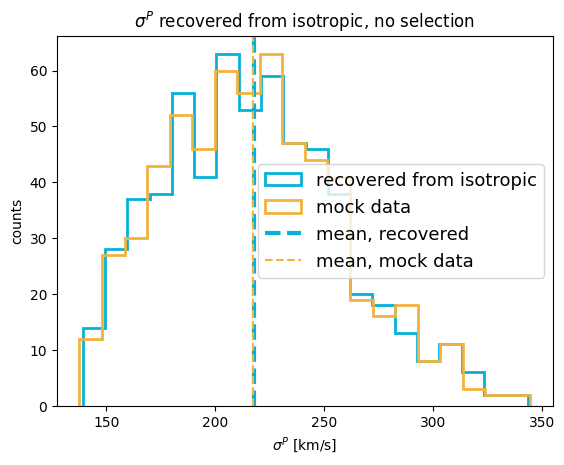

0.06305124016324892 %


In [20]:
if rerun_calculation:
    vel_disp_iso_all = recover_vel_disp(peak_lum, sigma_lum, qobs_data, peak_den, sigma_den, qobs_data, inc_recover_iso_all, distance)
mean_vel_disp_isoinc_no_sel = np.mean(vel_disp_iso_all)

plt.figure()
plt.hist(vel_disp_iso_all, histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(sigma_e_data, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_isoinc_no_sel, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from isotropic, no selection')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data, mean_vel_disp_isoinc_no_sel), '%')

## save data

In [21]:
if rerun_calculation:   
    with h5py.File('./kin_recovery_axisym_{}.hdf5' .format(oblate_name), 'w') as f:
        f.create_dataset(name='inc_recover_all', data = inc_recover_all)
        f.create_dataset(name='inc_recover_iso_all', data = inc_recover_iso_all)
        f.create_dataset(name='vel_disp_all', data = vel_disp_all)
        f.create_dataset(name='vel_disp_iso_all', data = vel_disp_iso_all)
        f.create_dataset(name='inc_recover_sel', data = inc_recover_sel)
        f.create_dataset(name='inc_recover_iso_sel', data = inc_recover_iso_sel)
        f.create_dataset(name='vel_disp_sel', data = vel_disp_sel)
        f.create_dataset(name='vel_disp_iso_sel', data = vel_disp_iso_sel)

In [22]:
def percent_err(x, x_ref):
    return (x - x_ref) / x_ref * 100

/tmp/ipykernel_2794283/3768489508.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


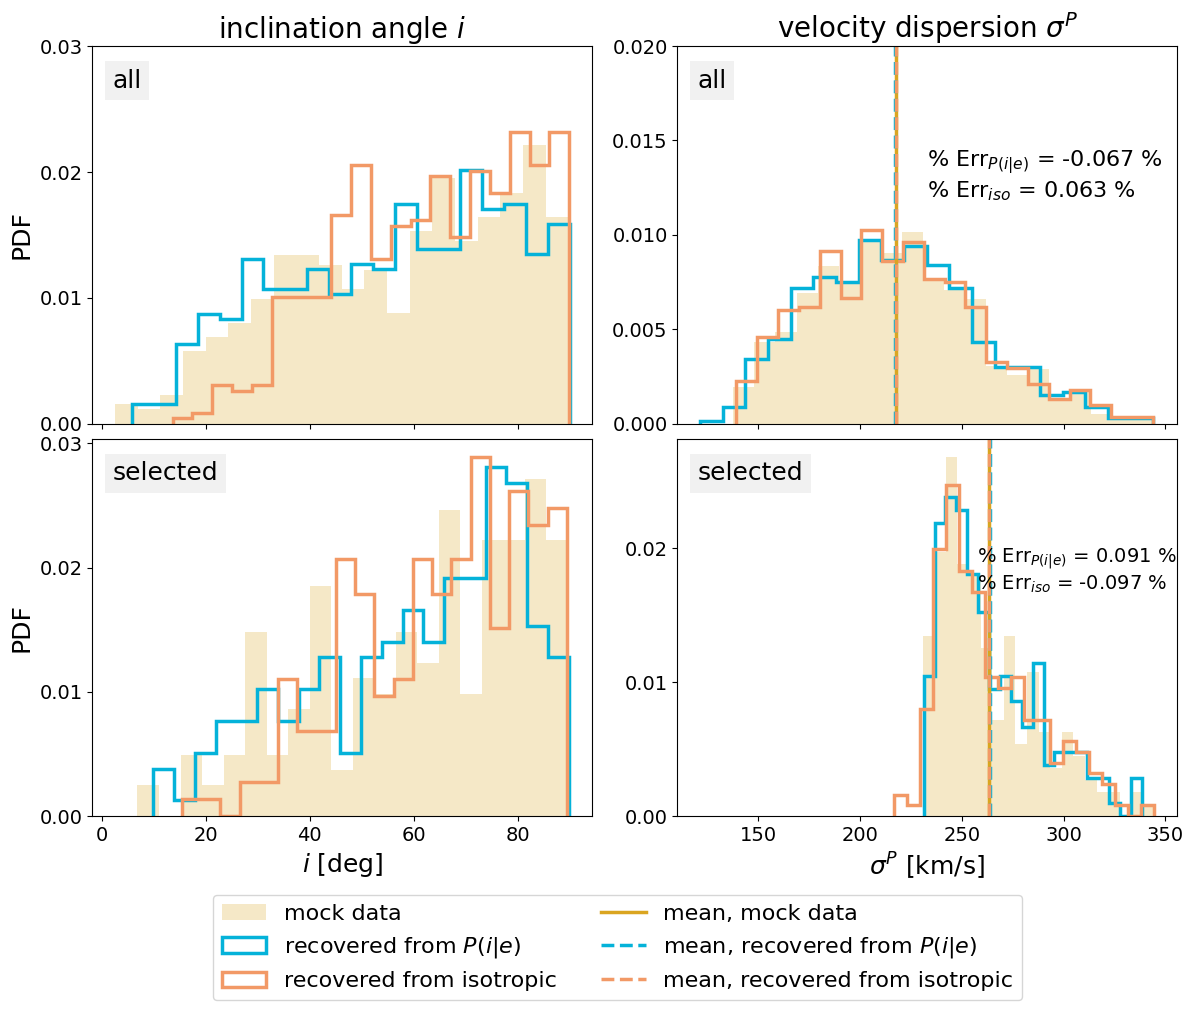

In [23]:
# Create a figure and a grid of subplots
fig = plt.figure(figsize = (14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.04, wspace = 0.17)
axs = gs.subplots(sharex='col')

color_pie = clist[0]
color_iso = clist[2]
color_data = 'goldenrod'

lw_hist = 2.5

# plot the (0, 0) subplot
axs[0, 0].hist(np.degrees(inc_recover_all), bins=20, label = r'recovered from $P(i\vert e)$', histtype='step', lw = lw_hist, density=True, color=color_pie)
axs[0, 0].hist(np.degrees(inc_recover_iso_all), bins=20, label = 'recovered from isotropic', histtype='step', lw = lw_hist, density=True, color=color_iso)
axs[0, 0].hist(inc_data, bins = 20, label = 'mock data', alpha = 0.25, density=True, color=color_data)
# set labels
axs[0, 0].set_xlabel('$i$ [deg]')
axs[0, 0].set_ylabel('PDF')
axs[0, 0].label_outer()
# axs[0, 0].sharey(axs[1, 0])
axs[0, 0].set_yticks(np.arange(0, 0.038, 0.01))
axs[0, 0].set_title('inclination angle $i$', fontsize=20)
# axs[0, 0].text(-45, 0.017, 'No \n selection', horizontalalignment='center', verticalalignment='center', fontsize=26)

# plot the (0, 1) subplot
axs[0, 1].hist(vel_disp_all, histtype='step', lw = lw_hist, label = r'recovered from $P(i\vert e)$', bins=20, density=True, color=color_pie)
axs[0, 1].hist(vel_disp_iso_all, histtype='step', lw = lw_hist, label = 'recovered from isotropic', bins=20, density=True, color=color_iso)
axs[0, 1].hist(sigma_e_data, alpha = 0.25, label = 'mock data', bins=20, density=True, color=color_data)
# plot the mean values
axs[0, 1].axvline(mean_sigma_e_data, marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)
axs[0, 1].axvline(mean_vel_disp_no_sel, marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)
axs[0, 1].axvline(mean_vel_disp_isoinc_no_sel, marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)
# set labels
# axs[0, 1].set_ylabel('PDF')
# axs[0, 1].sharey(axs[1, 1])
axs[0, 1].set_yticks(np.arange(0, 0.025, 0.005))
axs[0, 1].set_title(r'velocity dispersion $\sigma^P$', fontsize=20)
axs[0, 1].text(0.5, 0.6, s = r'% Err$_{P(i\vert e)}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_no_sel, mean_sigma_e_data)) +'\n' + r'% Err$_{iso}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_isoinc_no_sel, mean_sigma_e_data)), fontsize=16, transform = axs[0, 1].transAxes)

# plot the (1, 0) subplot
axs[1, 0].hist(np.degrees(inc_recover_sel), bins=20, histtype='step', label = r'recovered from $P(i\vert e)$', lw = lw_hist, density=True, color = color_pie)
axs[1, 0].hist(np.degrees(inc_recover_iso_sel), bins=20, histtype='step', label = 'recovered from isotropic', lw = lw_hist, density=True, color=color_iso)
axs[1, 0].hist(inc_data_sel, bins = 20, label='mock data', alpha = 0.25, density=True, color = color_data)
# set labels
axs[1, 0].set_xlabel('$i$ [deg]')
axs[1, 0].set_ylabel('PDF')
axs[1, 0].label_outer()
axs[1, 0].set_yticks(np.arange(0, 0.04, 0.01))
# axs[1, 0].text(-45, 0.017, 'With \n selection', horizontalalignment='center', verticalalignment='center', fontsize=26)


# plot the (1, 1) subplot
axs[1, 1].hist(vel_disp_sel, histtype='step', lw = lw_hist, label = r'recovered from $P(i\vert e)$', bins=20, density=True, color=color_pie)
axs[1, 1].hist(vel_disp_iso_sel, histtype='step', lw = lw_hist, label = 'recovered from isotropic', bins=20, density=True, color=color_iso)
axs[1, 1].hist(sigma_e_data_sel, alpha = 0.25, label = 'mock data', bins=20, density=True, color=color_data)
# plot the mean values
axs[1, 1].axvline(mean_sigma_e_data_sel, marker = ' ', ls = '-', label = 'mean, mock data', color=color_data, lw=lw_hist)
axs[1, 1].axvline(mean_vel_disp_sel, marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)
axs[1, 1].axvline(mean_vel_disp_isoinc, marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)
# set label
axs[1, 1].set_xlabel(r'$\sigma^P$ [km/s]')
axs[1, 1].set_yticks(np.arange(0, 0.038, 0.01))
# axs[1, 1].set_ylabel('PDF')
# annotate percent error
axs[1, 1].text(0.6, 0.6, s = r'% Err$_{P(i\vert e)}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_sel, mean_sigma_e_data_sel)) +'\n' + r'% Err$_{iso}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_isoinc, mean_sigma_e_data_sel)), fontsize=14, transform = axs[1, 1].transAxes)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# adjust axis label size
for ax in axs.flatten():
    ax.xaxis.label.set(fontsize=18)
    ax.yaxis.label.set(fontsize=18)
    ax.tick_params(axis='both', labelsize = 14)

# plot some dummy plots for legend making
dummy_labels = []
dummy_labels.append(patches.Patch(edgecolor='none', facecolor=color_data, label='mock data', alpha = 0.25))
dummy_labels.append(patches.Patch(edgecolor=color_pie, facecolor='none', label=r'recovered from $P(i\vert e)$', lw=lw_hist))
dummy_labels.append(patches.Patch(edgecolor=color_iso, facecolor='none', label='recovered from isotropic', lw=lw_hist))
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)[0])
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)[0])
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)[0])

fig.legend(handles=dummy_labels, loc='lower center', bbox_to_anchor=(0.5, -0.085), ncol=2, fontsize=16)

# annotate the with or without lensing selection
props = dict(boxstyle = 'square', facecolor = 'lightgray', alpha = 0.3, edgecolor = 'None')
for ax in axs[0]:
    ax.text(0.04, 0.89, 'all', transform = ax.transAxes, fontsize = 18, bbox=props)
for ax in axs[1]:
    ax.text(0.04, 0.89, 'selected', transform = ax.transAxes, fontsize = 18, bbox=props)

# plt.savefig('./kin_recovery_{}.pdf' .format(oblate_name), bbox_inches='tight', dpi=300)

plt.show()